# Peruvian GDP Nowcasting - SVM

The present document has the objective to perform Peruvian GDP nowcasting using Suport Vector Machine with a expanding window approach to assess the out-sample performance.

Writen by [José Diego Gallardo](https://josediegogallardo.github.io/), based in [Fetsami Araya](https://github.com/Fetsami-Araya)'s `nowcast_ml.py` script.

## Outline
- <a href='#lib'>1. Required Libraries</a>
- <a href='#user'>2. Information to be defined by user</a>
- <a href='#data_preprop'>3. Data preprocessing</a>
- <a href='#lasso_rol'>4. SVM with expanding window</a>
- <a href='#results'>5. Results</a>

## <a id='lib'>1. Required Libraries</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.exceptions import ConvergenceWarning

import time
import os, warnings
from datetime import date
from datetime import datetime


start_time = datetime.now()

## <a id='user'>2. Information to be defined by user</a>

In [2]:
p = 6 # Number of lags per variable
h = 6 # Horizont for rolling window

## <a id='data_preprop'>3. Data preprocessing</a>

In [3]:
# Original database
df = pd.read_csv(r'.\gdp_data.csv')
df = df.set_index("dates")

# Working database
lags = range(1, p+1)
Z = df
Z = Z.assign(**{
    f'{col} (t-{lag})': Z[col].shift(lag)
    for lag in lags
    for col in Z
})
Z = Z.dropna()

# Exogenous and endogenous vectors
X = Z.loc[:, Z.columns != 'gdp']
y = Z["gdp"]

# Dates range
rw_date_range = pd.date_range(start=Z.index[-h-1], periods=h+1, freq  = 'MS')

# Iterable Date range
rw_date_range = rw_date_range.format()
rw_hor = len(rw_date_range)

## <a id='lasso_rol'>4. SVM with expanding window</a>

In [4]:
rmse = {}
y_act = {}
y_hat = {}

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    for i in range(1,rw_hor):

        X_train = X[:rw_date_range[i-1]]
        y_train = y[:rw_date_range[i-1]]
        X_test = X[rw_date_range[i]:rw_date_range[i]]
        y_test = y[rw_date_range[i]:rw_date_range[i]]

        ## Grid Search + time series cross-validation
        parameters = {'kernel':('rbf','linear','poly'),
                'degree' : [3,4,5],
                'gamma' : ('scale','auto'),
                'C': [1,2],
                'shrinking': (True,False)}
        
        svm = SVR(cache_size=3500)
        svm_cv = GridSearchCV(svm,
                              parameters, # Hyperparameters Gridsearch
                              cv=TimeSeriesSplit(n_splits=5)) # Time series cross-valdiation
        svm_cv_fit = svm_cv.fit(X_train,y_train)
        best_params = svm_cv_fit.best_params_

        ## GBTree estimation with the best set of hyperparameter
        svm_est = SVR(kernel=best_params['kernel'],
                      degree=best_params['degree'],
                      gamma=best_params['gamma'],
                      C= best_params['C'],
                      shrinking= best_params['shrinking']).fit(X_train,y_train)
        ## GBTree prediction
        y_hat_test = svm_est.predict(X_test)

        ## Saving data
        y_act[rw_date_range[i]] = y_test.item()
        y_hat[rw_date_range[i]] = y_hat_test.item()

## <a id='results'>5. Results</a>

              actual  forecast
dates                         
2019-07-01  3.912189  3.498137
2019-08-01  3.697635  3.892764
2019-09-01  2.489750  3.343127
2019-10-01  2.678191  3.142372
2019-11-01  2.267064  2.856537
2019-12-01  1.153884  3.125412


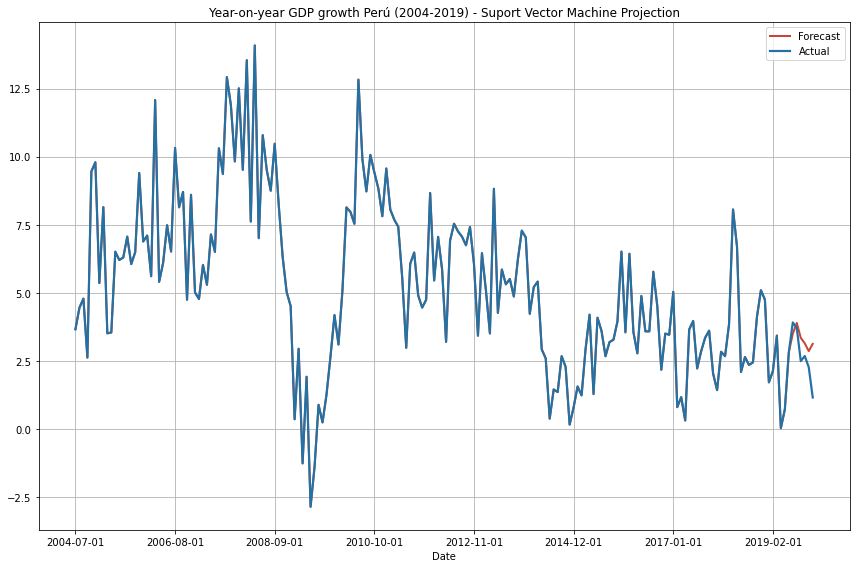

In [5]:
## Actual and proyection data
y_hat4plot = y.copy()

for i in range(1,rw_hor):
    y_hat4plot[rw_date_range[i]] = y_hat[rw_date_range[i]]

data = {"actual": y, 
        "forecast": y_hat4plot} 
df4plot = pd.concat(data, 
               axis = 1) 
print(df4plot.tail(h))

## Results plot
df4plot['forecast'].plot(figsize=[12,8],
                            color = '#CB4335',
                            linewidth=2,
                            label = 'Forecast')
df4plot['actual'].plot(figsize=[12,8],
                            color = '#2471A3',
                            linewidth=2.2,
                            label = 'Actual')
plt.xlabel('Date')
plt.title('Year-on-year GDP growth Perú (2004-2019) - Suport Vector Machine Projection')
plt.grid(which='major')
plt.legend()
plt.tight_layout()

In [6]:
end_time = datetime.now()
print('Duracion: {}'.format(end_time - start_time))

Duracion: 1:58:42.338372
